# 3.1 分類アルゴリズムの選択
特定の問題に適した分類アルゴリズムを選択するには，練習が必要である．
# 3.2 scikit-learn 活用へのファーストステップ

In [1]:
from sklearn import datasets
import numpy as np
# Iris データセットをロード
iris = datasets.load_iris()
# 3,4番目の特徴量を抽出
X = iris.data[:, [2, 3]]
# クラスラベルを取得
y = iris.target
# 一意なクラスラベルを出力
print('Class labels:', np.unique(y))

Class labels: [0 1 2]


メモリの節約などのために基本的にラベルは文字列は用いない．クラスラベルを整数で符号化するのが一般的．ここでもIris-setosa, Iris-versicolor, Iris-virginicaをそれぞれ0, 1, 2としている．

In [2]:
from sklearn.model_selection import train_test_split
# トレーニングデータとテストデータに分割
# 全体の30%をテストデータにする
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)

random_state=1とすることでデータセットを分割する前のシャッフルを再現可能になる．stratify=yは層化サンプリングを利用している．トレーニングサブセットとテストサブセットに含まれるクラスラベルの比率が入力データセットと同じであることを意味する．bincount関数は配列内の各値の出現回数を数える．下の通り，クラスラベルの比率が同じになっている．

In [3]:
print("Labels counts in y:", np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))

Labels counts in y: [50 50 50]
Labels counts in y_train: [35 35 35]
Labels counts in y_test: [15 15 15]


In [4]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
# トレーニングデータの平均と標準偏差を計算
sc.fit(X_train)
# 平均と標準偏差を用いて標準化
X_train_std = sc.transform(X_train)
X_test_std =  sc.transform(X_test)

StandardScalerのfitメソッドを呼び出すことで，トレーニングデータから特徴量ごとにパラメータ平均値と標準偏差を推定している．
トレーニングデータセットを標準化したところで，パーセプトロンモデルをトレーニングできる状態になる．

In [5]:
from sklearn.linear_model import Perceptron
# エポック数４０，学習率0.1でパーセプトロンのインスタンスを生成
ppn = Perceptron(n_iter=40, eta0=0.1, random_state=1)
# トレーニングデータをモデルに適合させる
ppn.fit(X_train_std, y_train)

Perceptron(alpha=0.0001, class_weight=None, eta0=0.1, fit_intercept=True,
      n_iter=40, n_jobs=1, penalty=None, random_state=1, shuffle=True,
      verbose=0, warm_start=False)

In [6]:
# テストデータで予測を開始
y_pred = ppn.predict(X_test_std)
# 誤分類のサンプルの個数を表示
print('Misclassified samples: %d' % (y_test != y_pred).sum())

Misclassified samples: 3


パーセプトロンが４５個のサンプルのうち３つを誤分類することがわかる．誤分類率は約6.3%である．つまり，正解率は93.3％だ．

scikit-learnでは様々な性能指標を計算する機能も搭載されている．metricsモジュールによって実装されている．
たとえば，テストデータセットでのパーセプトロンの正解率は，次のように計算できる．

In [7]:
from sklearn.metrics import accuracy_score
# 分類の正解率を表示
print('Accuracy: %.2f' % ppn.score(X_test_std, y_test))

Accuracy: 0.93


In [8]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt


def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # マーカーとカラーマップの準備
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # 決定領域のプロット
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    # グリッドポイントの生成
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    # 各特徴量を１次元配列に変換して予測を実行
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    # 予測結果を元のグリッドポイントのデータサイズに変換
    Z = Z.reshape(xx1.shape)
    # グリッドポイントの等高線のプロット
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    # 軸の範囲の設定
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # クラスごとにサンプルをプロット
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

    # テストサンプルを目立たせる(点を○で表示)
    if test_idx:
        # 全てのサンプルをプロット
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='test set')

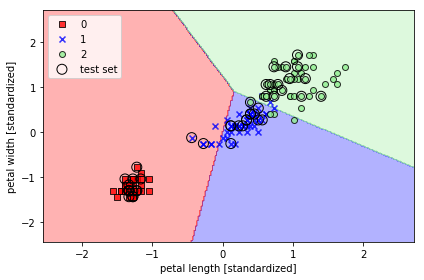

In [9]:
# トレーニングデータとテストデータの特徴量を行方向に結合
X_combined_std = np.vstack((X_train_std, X_test_std))
# トレーニングデータとテストデータのクラスラベルを結合
y_combined = np.hstack((y_train, y_test))
# 決定境界のプロット
plot_decision_regions(X=X_combined_std, y=y_combined, classifier=ppn, test_idx=range(105,150))
# 軸のラベル設定
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
# 凡例の設定（左上に表示）
plt.legend(loc='upper left')
# グラフを表示
plt.tight_layout()
plt.show()



このグラフを見ればわかるように，３つの品種を線形の決定領域で完全に区切ることは出来ない．完全な線形分離が不可能なデータセットでは，パーセプトロンアルゴリズムは決して収束しない．以降の節では，クラスが完全に線形分離出来ない場合であってもコストの最小値に収束する，より強力な分類器を取り上げる．

# 3.3 ロジスティック回帰を使ってクラスの確率を予測するモデルの構築
ロジスティック回帰は線形分離問題と二値分類問題に対する単純ながら強力なアルゴリズムである．そして，名前とは裏腹に回帰ではなく分類のためのモデルである．
サンプルが特定のクラスに属している確率を予測するためにシグモイド関数という関数を利用する．

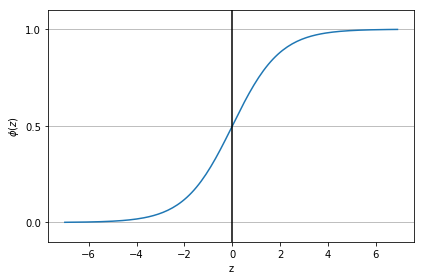

In [10]:
import matplotlib.pyplot as plt
import numpy as np
# シグモイド関数を定義
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-z))

# 0.1間隔で-7以上7未満のデータを生成
z = np.arange(-7, 7, 0.1)
# 生成したデータでシグモイド関数を実行
phi_z = sigmoid(z)
#　元のデータとシグモイド関数の出力をプロット
plt.plot(z, phi_z)
# 垂直線を追加（z=0）
plt.axvline(0.0, color='k')
# y軸の上限/下限を設定
plt.ylim(-0.1, 1.1)
# 軸のラベルを追加
plt.xlabel('z')
plt.ylabel('$\phi (z) $')
# y軸の目盛を追加
plt.yticks([0.0, 0.5, 1.0])
# Axesクラスのオブジェクト取得
ax = plt.gca()
# y軸の目盛に合わせて水平グリッド線追加
ax.yaxis.grid(True)
# グラフを表示
plt.tight_layout()
plt.show()

$\phi (z)$の様々な値に対する1つのサンプルの分類コストを具体的に示すグラフのコード

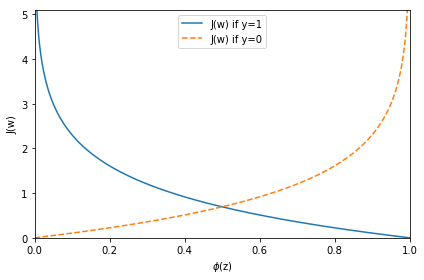

In [11]:
# y=1のコストを計算する関数
def cost_1(z):
    return - np.log(sigmoid(z))

# y=0のコストを計算する関数
def cost_0(z):
    return - np.log(1 - sigmoid(z))

# 0.1間隔で-10以上10未満のデータを生成
z= np.arange(-10, 10, 0.1)
# シグモイド関数を実行
phi_z = sigmoid(z)
# 結果をプロット
plt.plot(phi_z, cost_1(z), label='J(w) if y=1')
# 結果をプロット
plt.plot(phi_z, cost_0(z), linestyle="--", label='J(w) if y=0')
# x軸の下限/上限を設定
plt.ylim(0.0, 5.1)
plt.xlim([0, 1])
# 軸のラベルを設定
plt.xlabel('$\phi$(z)')
plt.ylabel('J(w)')
# 凡例を設定
plt.legend(loc='upper center')
# グラフを表示
plt.tight_layout()
plt.show()

グラフから正しく予測をすれば，コストは0に近づき，間違えれば無限大に向かうことがわかる．

# 3.3.3 ADALINE実装をロジスティック回帰のアルゴリズムに変換する
コスト関数を置き換える．線形活性化関数をシグモイド活性化関数に置き換える．しきい値関数を書き換えて，-1,1の代わりにクラスラベル0と1を返すようにする．

In [12]:
class LogisticRegressionGD(object):
    """Logistic Regression Classifier using gradient descent.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.


    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    cost_ : list
      Logistic cost function value in each epoch.

    """
    def __init__(self, eta=0.05, n_iter=100, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
          Training vectors, where n_samples is the number of samples and
          n_features is the number of features.
        y : array-like, shape = [n_samples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            
            # note that we compute the logistic `cost` now
            # instead of the sum of squared errors cost
            cost = -y.dot(np.log(output)) - ((1 - y).dot(np.log(1 - output)))
            self.cost_.append(cost)
        return self
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, z):
        """Compute logistic sigmoid activation"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, 0)
        # equivalent to:
        # return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

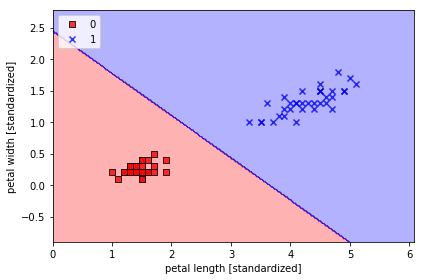

In [13]:
X_train_01_subset = X_train[(y_train == 0) | (y_train == 1)]
y_train_01_subset = y_train[(y_train == 0) | (y_train == 1)]

lrgd = LogisticRegressionGD(eta=0.05, n_iter=1000, random_state=1)
lrgd.fit(X_train_01_subset,
         y_train_01_subset)

plot_decision_regions(X=X_train_01_subset, 
                      y=y_train_01_subset,
                      classifier=lrgd)

plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
#plt.savefig('images/03_05.png', dpi=300)
plt.show()

# 3.3.4 scikit-learnを使ったロジスティック回帰モデルのトレーニング
この実装では他クラス分類の設定も標準でサポートされている．

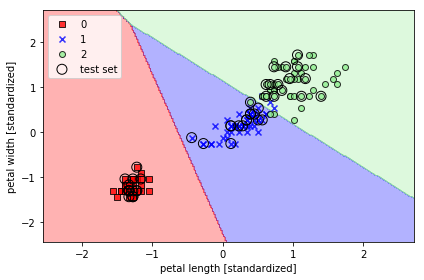

In [14]:
from sklearn.linear_model import LogisticRegression
# ロジスティック回帰のインスタンスを生成
lr = LogisticRegression(C=100.0, random_state=1)
# トレーニングデータをモデルに適合させる
lr.fit(X_train_std, y_train)
# 決定領域をプロット
plot_decision_regions(X_combined_std, y_combined, classifier=lr, test_idx=range(105, 150))
# 軸ラベルの設定
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
# 凡例を表示
plt.legend(loc='upper left')
# グラフを表示
plt.tight_layout()
plt.show()

ロジスティック回帰インスタンスのパラメータCについては後述．トレーニングサンプルが特定のクラスに属する確率はpredict_probaメソッドを使って計算できる．

In [15]:
lr.predict_proba(X_test_std[:3,:])

array([[  3.20136878e-08,   1.46953648e-01,   8.53046320e-01],
       [  8.34428069e-01,   1.65571931e-01,   4.57896429e-12],
       [  8.49182775e-01,   1.50817225e-01,   4.65678779e-13]])

1行目は1つ目のサンプルに関するクラスの所属確率を表している，2行目は2つ目のサンプルに関するクラスの所属確率を表している．列の合計は1になる．クラスラベルの予測値を取得するためには各行で最大の列を特定すれば良い．

In [16]:
lr.predict_proba(X_test_std[:3, :]).argmax(axis=1)

array([2, 0, 0])

In [17]:
lr.predict(X_test_std[:3, :])

array([2, 0, 0])

このように1つ目のサンプルはクラスラベル２(Iris-Virginica)に属し，２つ３つはクラスラベル０（Iris-setosa）と予測していることがわかる．<br>
最後に，単一のサンプルのクラスラベルを予測したい場合に注意しなければならない点が１つある．scikit-learnはデータ入力として２次元配列を期待する．最初に１行のデータを２次元データ配列に変換する必要がある．NumPyのreshapeメソッドを使って新しい次元を追加できる．

In [18]:
lr.predict(X_test_std[0, :].reshape(1, -1))

array([2])

# 3.3.5 正則化による過学習への対処
過学習はトレーニングデータセットではうまく機能するモデルが，未知のデータ(テストデータセット)ではうまく汎化されないという問題だ．過学習が発生しているモデルは「バリアンスが高い」(high variance)とも表現される．原因として，パラメータの数が多すぎるために，データに対してモデルが複雑すぎることが考えられる．<br>
同様に，モデルは学習不足に陥ることもある．トレーニングデータセットのパターンをうまく捕捉するにはモデルの複雑さが十分でなく，未知のデータに対する性能が低いことを意味する．「バイアスが高い」(high bias)ともいう．<br>
バイアスとバリアンスのトレードオフを探る方法の１つとして，正則化に基づいてモデルの複雑さを調整することが挙げられる．正則化は共線性を処理する非常に便利な手法であり，データからノイズを取り除き，最終的に過学習を防ぐ．共線性とは，特徴量の間の相関の高さのことである．正則化の背景にある考え方は，極端なパラメータの重みにペナルティを科すための追加情報（バイアス）を導入するというものである．最も一般的な正則化は，L2正則化(L2 regularization)である．<br>
正則化を適用するためにはロジスティック回帰で定義したコスト関数に対して，重みを小さくするための正則化の項を追加すれば良い．scikit-learnのLogisticRegressionクラスに実装されているパラメータCはサポートベクトルマシンの慣例に由来する．Cは正則化パラメータ $\lambda$に直接関連しており，その逆数である．したがって．逆正則化パラメータCの値を減らすことは，正則化の強さを高めることを意味する．正則化の強さを可視化するためには２つの重み係数と逆正則化パラメータとの関係をプロットすればいい．

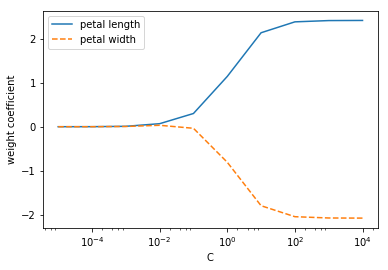

In [19]:
# 空のリストを生成(重み係数，逆正則化パラメータ)
weights, params = [], []
# 10個の逆正則化パラメータに対応するロジスティック回帰モデルをそれぞれ処理
for c in np.arange(-5, 5):
    lr = LogisticRegression(C=10.**c, random_state=1)
    lr.fit(X_train_std, y_train)
    # 重み係数を格納
    weights.append(lr.coef_[1])
    # 逆正則化パラメータを格納
    params.append(10.**c)
    
# 重み係数をNumPy配列に変換
weights = np.array(weights)
# 横軸のに逆正則化パラメータ，縦軸に重み係数をプロット
plt.plot(params, weights[:, 0], label='petal length')
plt.plot(params, weights[:, 1], linestyle='--', label='petal width')
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.legend(loc='upper left')
# 横軸を対数スケールに設定
plt.xscale('log')
plt.show()

パラメータCが減少し，正則化の強さが増すと，重み係数0に近づいていく．

# 3.4 サポートベクトルマシンによる最大マージン分類
SVMでの最適化の目的は，マージンを最大化することである．マージンは超平面と，この超平面に最も近いトレーニングサンプルとの間の距離として定義される．超平面に最も近いトレーニングサンプルはサポートベクトルと呼ばれる．
## 3.4.1 最大マージンを直感的に理解する
決定境界のマージンを大きくする理論的根拠は，汎化性能が小さくなる傾向にあることである．

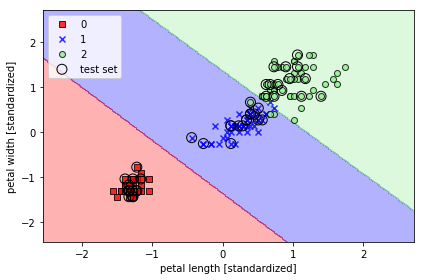

In [20]:
from sklearn.svm import SVC

svm = SVC(kernel='linear', C=1.0, random_state=1)
svm.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined, classifier=svm, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('images/03_11.png', dpi=300)
plt.show()

scikit-learnではいくつかの代替実装がある。データセットが大きすぎてコンピュータメモリに収まらないときなど。

In [21]:
from sklearn.linear_model import SGDClassifier
# 確率的勾配降下法バージョンのパーセプトロンを生成
ppn = SGDClassifier(loss='perceptron')
# 確率的勾配降下法バージョンのロジスティック回帰を生成
lr = SGDClassifier(loss='log')
# 確率的勾配降下法バージョンのSVM(損失関数=ヒンジ関数)を生成
svm = SGDClassifier(loss='hinge')

# 3.5 カーネルSVMを使った非線形問題の求解
SVMが人気な理由の一つが非線形分類問題を解くために「カーネル化」するのが容易であることだ。
## 3.5.1 線形分離不可能なデータに対するカーネル法
XORゲート形式の単純なデータセットを作成する。

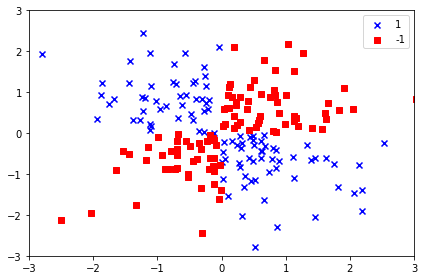

In [22]:
import matplotlib.pyplot as plt
import numpy as np
# 乱数シードを指定
np.random.seed(1)
# 標準正規分布に従う乱数で200行２列の行列を生成
X_xor = np.random.randn(200, 2)
# ２つの引数に対して排他的論理和を実行
y_xor = np.logical_xor(X_xor[:, 0] > 0, X_xor[:, 1] > 0)
# 排他的論理和の値が真の場合は１、偽の場合は-１を割り当てる
y_xor = np.where(y_xor, 1, -1)
# ラベル１を青のxでプロット
plt.scatter(X_xor[y_xor==1, 0], X_xor[y_xor==1, 1],
           c='b', marker='x', label='1')
# ラベル-１を赤のxでプロット
plt.scatter(X_xor[y_xor==-1, 0], X_xor[y_xor==-1, 1],
           c='r', marker='s', label='-1')
# 軸の範囲を設定
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.legend(loc='best')
plt.tight_layout()
plt.show()

見ての通り線形超平面の決定境界に基づいて分割することは不可能であることが分かる。
射影関数 $\phi$を使って高次元空間へ射影して、線形分離できるようにすることがカーネル手法の基本的な発想。２次元のデータセットを３次元の特徴空間に変換することができる。
$$
    \phi(x_1, x_2) = (z_1, z_2, z_3) = (x_1, x_2, x_1^2+x_2^2)
$$

次元を増やして線形超平面を使って分割できるようになる。それを元の特徴空間へ射影すると、非線形の決定境界になる。
## 3.5.2 カーネルトリックを使って分離超平面を高次元空間で特定する
SVMを使って非線形問題の解を求めるには、射影関数$ \phi $を使ってトレーニングデータセットをより高い次元の特徴空間に変換し、この新しい特徴空間でデータを分類するための線形SVMモデルをトレーニングする。そうすると、同じ射影関数$ \phi $を使って新しい未知のデータを変換し、線形のSVMを使って分類できるようになる。<br>
ただし、この射影方法には１つ問題があって、新しい特徴量を生成する計算コストが非常に高いことである。ここでものをいうのが、「カーネルトリック」である。

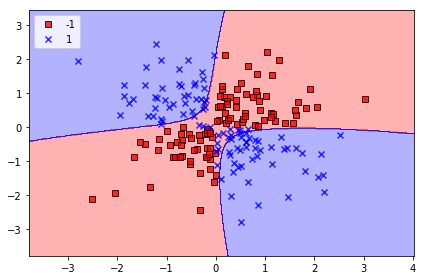

In [23]:
# RBFカーネルによるSVMのインスタンスを生成
svm = SVC(kernel='rbf', random_state=1, gamma=0.10, C=10.0)
svm.fit(X_xor, y_xor)
plot_decision_regions(X_xor, y_xor, classifier=svm)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

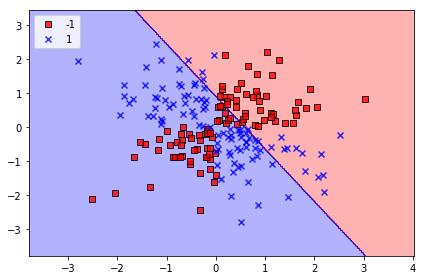

In [24]:
# SVMのインスタンスを生成
svm = SVC(kernel='linear', random_state=1, gamma=0.10, C=10.0)
svm.fit(X_xor, y_xor)
plot_decision_regions(X_xor, y_xor, classifier=svm)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

結果からわかるようにカーネルSVMはXORデータをかなりうまく分類できる。$\gamma$パラメータについては、このカーネル関数（ガウスカーネル）の「カットオフ（限界値条件）」パラメータであると解釈できる。基本的に$\gamma$パラメータの値を大きくすると、トレーニングサンプルの影響力が大きくなり、到達範囲が広くなる。それにより、決定境界が狭くなり突き出したようになる。$\gamma$パラメータに対する直感を養うために、RBFカーネルSVMをIrisデータセットに適用してみる。

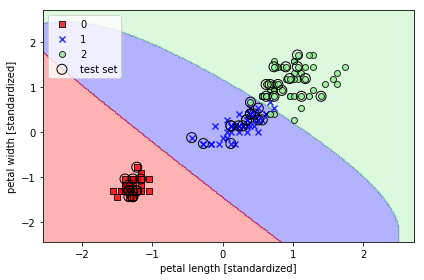

In [25]:
# RBFカーネルによるSVMのインスタンスを生成（２つのパラメータを変更）
svm = SVC(kernel='rbf', random_state=1, gamma=0.2, C=1.0)
svm.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std, y_combined, classifier=svm, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

$\gamma$パラメータには比較的小さい値を選んだが、RBFカーネルによるSVMモデルの決定境界はかなりなめらかになる。

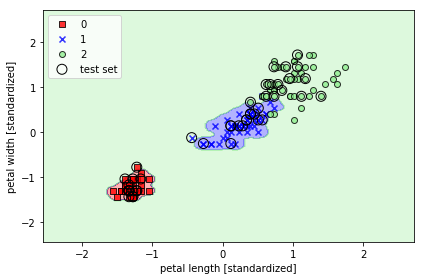

In [26]:
# RBFカーネルによるSVMのインスタンスを生成（γパラメータを変更）
svm = SVC(kernel='rbf', random_state=1, gamma=100, C=1.0)
svm.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std, y_combined, classifier=svm, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

$\gamma$パラメータに比較的大きな値を使用すると、クラス０とクラス１の周りの決定境界がかなり複雑になることがわかる。このモデルはトレーニングデータには非常によく適合するが、未知のデータで高い汎化誤差が生じることが考えられる。これは過学習を抑えるためにも$\gamma$パラメータの最適化が重要な役割を果たすことを示している。
# 決定木学習
決定木（decision tree）分類器は、意味解釈可能性（interpretability : 得られた結果の意味を解釈しやすいかどうか）に配慮する場合に魅力的なモデルである。一連の質問に基づいて決断を下すという方法により、データを分類するモデルであると考えることができる。決定木モデルでは、トレーニングデータセットの特徴量に基づいて一連の質問を学習し、サンプルのクラスラベルを推測する。Irisデータに適応すると、例えば「がく片の長さ」の特徴軸に沿ってカットオフ（しきい）値を定義し、「がく片の長さは2.8cm以上か」という二択質問をするだけでよい。 <br>
決定木アルゴリズムを用いて、決定木の根（ルート）か始めて、情報利得（information gain : 分割された集合の要素についてのばらつきの減少）が最大となる特徴量でデータを分割する。葉（リーフ）が純粋になる（分割されたデータのばらつきの減少がなくなる）まで、この分割を子ノード（分岐条件）ごとに繰り返すことが出来る。葉が純粋になるとは、各リーフのサンプルがすべて同じクラスに属することを意味する。しかし、実際に葉が純粋になるまで分割を繰り返すと多くのノードを持つ非常に深い決定木になることがあり、過学習に陥りやすい。そのために、通常は決定木の最大の深さに制限を設けて、決定木を「剪定（ prune）」したい。

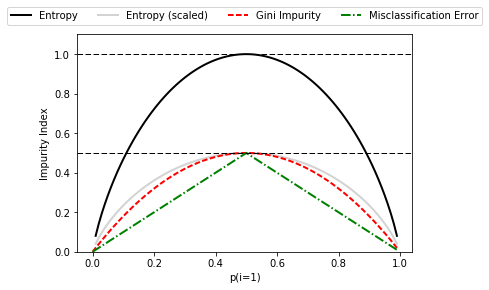

In [27]:
import matplotlib.pyplot as plt
import numpy as np
# ジニ不純度の関数を定義
def gini(p):
    return (p) * (1 - (p)) + (1 - p) * (1- (1 - p))

# エントロピーの関数を定義
def entropy(p) :
    return - p*np.log2(p) - (1 - p)*np.log2((1 - p))

# 分類誤差の関数を定義
def error(p):
    return 1 - np.max([p, 1- p])

# 確率を表す配列を生成（０から0.99まで０．０１刻み）
x = np.arange(0.0, 1.0, 0.01)
# 配列の値をもとにエントロピー、分類誤差を計算
ent = [entropy(p) if p != 0 else None for p in x]
sc_ent = [e*0.5 if e else None for e  in ent]
err = [error(i)  for i in x]
# 図の作成
fig = plt.figure()
ax = plt.subplot(111)
# エントロピー（２種）、ジニ不純度、分類誤差のそれぞれをループ処理
for i, lab, ls, c, in zip([ent, sc_ent, gini(x), err],
                         ['Entropy', 'Entropy (scaled)',
                         'Gini Impurity', 'Misclassification Error'],
                         ['-', '-', '--', '-.'],
                         ['black', 'lightgray', 'red', 'green', 'cyan']):
    line = ax.plot(x, i, label=lab, linestyle=ls, lw=2, color=c)
    
# 凡例の設定（中央の上に配置）
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
         ncol=5, fancybox=True, shadow=False)
# ２本の水平の破線を引く
ax.axhline(y=0.5, linewidth=1, color='k', linestyle='--')
ax.axhline(y=1.0, linewidth=1, color='k', linestyle='--')
# 横軸の上限/下限を設定
plt.ylim([0, 1.1])
plt.xlabel('p(i=1)')
plt.ylabel('Impurity Index')
plt.show()

 ## 3.6.2 決定木の構築
決定木学習では、特徴量空間を矩形に分割することで複雑な決定境界を構築できる。ただし、決定木が深くなれば深くなるほど決定境界は複雑になり、過学習に陥りやすくなる。不純度の条件としてエントロピーを使って最大の深さが４の決定木をトレーニングする。決定木では特徴量をスケーリングしてもしきい値の値が変化するに過ぎず、サンプルの分割には影響を与えない。

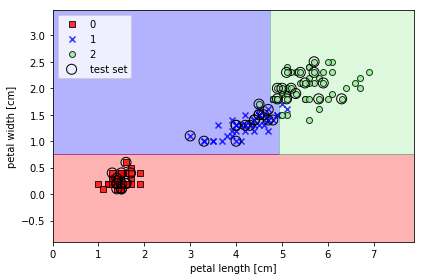

In [28]:
from sklearn.tree import DecisionTreeClassifier
# エントロピーを指標とする決定木のインスタンスを生成
tree = DecisionTreeClassifier(criterion='gini', max_depth=4, random_state=1)
# 決定木のモデルをトレーニングデータに適合させる
tree.fit(X_train, y_train)
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X_combined, y_combined, classifier=tree,
                     test_idx=range(105, 150))
plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

トレーニング後の決定木を.dotファイルとしてエクスポートできる機能がある。決定木の画像をPNGフォーマットでローカルディレクトリに作成するコードは次のようになる。

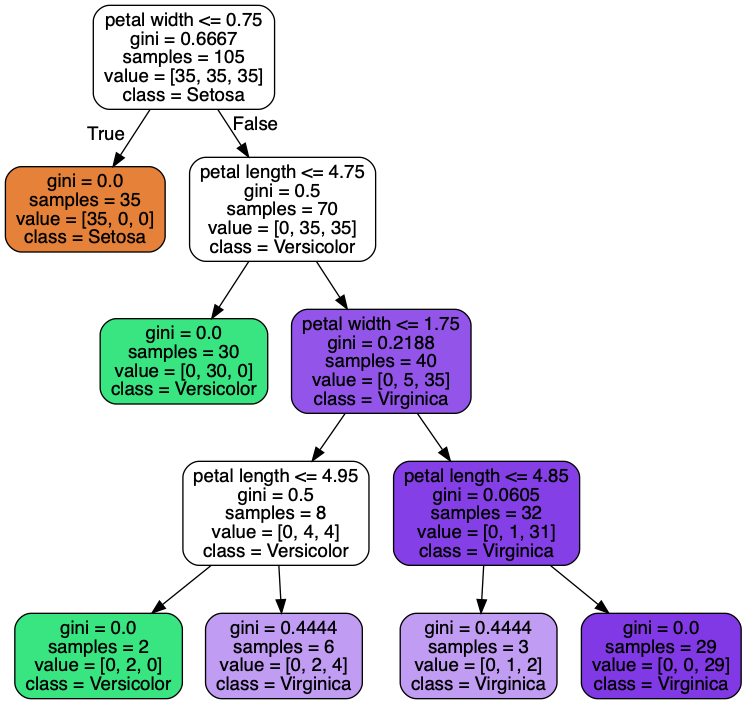

In [33]:
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz
from IPython.display import Image

dot_data = export_graphviz(tree,
                           filled=True, 
                           rounded=True,
                           class_names=['Setosa', 
                                        'Versicolor',
                                        'Virginica'],
                           feature_names=['petal length', 
                                          'petal width'],
                           out_file=None) 
graph = graph_from_dot_data(dot_data) 
graph.write_png('tree.png') 
Image('tree.png', width=600)